**Name:** \_\_\_\_\_

**EID:** \_\_\_\_\_

# CS5489 - Tutorial 9
## Face Detection with CNNs

In the previous tutorial, you used an MLP to detect a face in a small image patch.
In this tutorial you will train a CNN instead of an MLP.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
import skimage.io
import skimage.color
import skimage.transform
from scipy import ndimage

Next we will load keras and tensorflow.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import struct
K.set_image_data_format('channels_last')
print(keras.__version__, tf.__version__)

2.4.0 2.4.1


## 1. Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and place it in the same directory as this ipynb file.  **Do not unzip it.** Then run the following cell to load the images.

In [3]:
imgdata = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

# the dataset is too big, so subsample the training and test sets...
# reduce training set by a factor of 4
train_subsample = 1
train_counter = [0, 0]
# maximum number of samples in each class for test set
test_maxsample = 472
test_counter = [0, 0]

# load the zip file
filename = 'faces.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "faces/*/*/*.png"):
        
        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        loadme = False
        if fset == 'train':
            if (train_counter[myclass] % train_subsample) == 0:
                loadme = True
            train_counter[myclass] += 1
        elif fset == 'test':
            if test_counter[myclass] < test_maxsample:
                loadme = True
            test_counter[myclass] += 1
            
        if (loadme):
            # open file in memory, and parse as an image
            myfile = zfile.open(name)
            #img = matplotlib.image.imread(myfile)
            img = skimage.io.imread(myfile)
            # convert to grayscale
            img = skimage.color.rgb2gray(img)
            myfile.close()
            
            # append data
            imgdata[fset].append(img)
            classes[fset].append(myclass)

        
zfile.close()
imgsize = img.shape

print(len(imgdata['train']))
print(len(imgdata['test']))
trainclass2start = sum(classes['train'])

<ipython-input-3-b3235342933c>:43: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img = skimage.color.rgb2gray(img)


6977
944


Next we will convert the list of images into a block (array) of images for easier processing.

In [4]:
# convert list to numpy array
trainY = asarray(classes['train'])
testY  = asarray(classes['test'])

# convert class labels to binary indicators
trainYb = keras.utils.to_categorical(trainY)
testYb  = keras.utils.to_categorical(testY)

# convert list of ndarray to ndarray
trainI = asarray(imgdata['train']).reshape((6977,19,19,1))
testI  = asarray(imgdata['test']).reshape((944,19,19,1))

# cleanup memory
del imgdata

# shuffle the data (since it is in order by class)
random.seed(123)
inds1 = random.permutation(len(trainI)).tolist()
inds2 = random.permutation(len(testI)).tolist()
trainYb = trainYb[inds1]
testYb  = testYb[inds2]
trainY = trainY[inds1]
testY  = testY[inds2]
trainI = trainI[inds1]
testI = testI[inds2]

print(trainI.shape)
print(testI.shape)

(6977, 19, 19, 1)
(944, 19, 19, 1)


Each image is a 19x19x1 array of pixel values.  The last dimension is the number of channels in the image - in this case the image is grayscale, so there is only 1 channel.  Run the below code to show an example:

(19, 19)


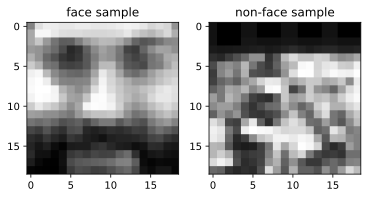

In [5]:
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(squeeze(trainI[1]), cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(squeeze(trainI[2]), cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

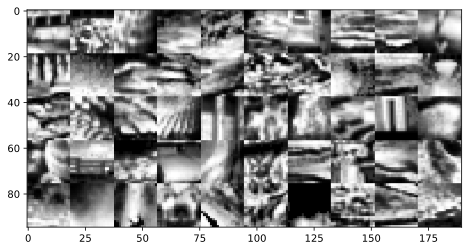

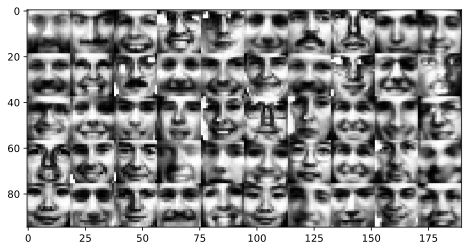

In [6]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(squeeze(X[i]))
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show images in a plot
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    # nc is the number of columns
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                if isinstance(titles, str):
                    plt.title(titles.format(idx))
                else:
                    plt.title(titles[idx])
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()

# show a few images
plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,0]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,1]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

Next we will generate the training/validation set from the training data.

In [7]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  model_selection.train_test_split(trainI, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4488)

# make validation data
validsetI = (validI, validYb)

print(vtrainI.shape)
print(validI.shape)

(6279, 19, 19, 1)
(698, 19, 19, 1)


Here are some useful functions.

In [8]:
# compatible with v1 or v2
def tf_compat():
    if tf.__version__[0] == '1':
        return (tf.set_random_seed, 'acc')
    else:
        return (tf.random.set_seed, 'accuracy')
    
tf_set_seed, accname = tf_compat()

def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if accname in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history[accname], 'b', label="training acc ({:.4f})".format(history.history[accname][-1]))
        ax2.plot(history.history['val_'+accname], 'b--', label="validation acc ({:.4f})".format(history.history['val_'+accname][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

Now let's try a simple logistic regression classifier, trained using Keras. Since the inputs are images, we will convert the input image into a vector using the "Flatten" layer first.

Epoch 00016: early stopping
test accuracy: 0.6228813559322034


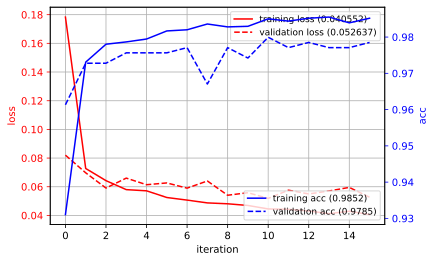

In [9]:
# initialize random seed
K.clear_session()
random.seed(4487); tf_set_seed(4487)

# build the network for logistic regression
nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # vectorize the input image
nn.add(Dense(units=2, activation='softmax'))  # classification layer (2 classes)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_'+accname,             # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.9, nesterov=True), 
           metrics=['accuracy']  # also calculate accuracy during training
          )

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI,  # specify the validation set
                 verbose=False)

plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

## 2. Detection using CNN

Train an CNN to classify an image patch as face or not face.  Use  `vtrainI` and `vtrainY` as the training set and `validsetI` as the validation set.  You can try different architectures, and adjust values of the learning rates, number of iterations, early stopping, regularization, etc. to get a good result.  Use a large batch size (e.g., 50) to speed up the training time.  Remember to add the `callbacks` so that you can monitor the training process.

In [10]:
### INSERT YOUR CODE HERE



Epoch 00016: early stopping
test accuracy: 0.6716101694915254


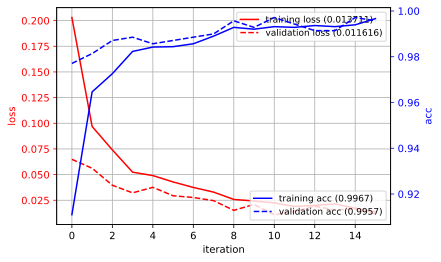

In [11]:
# conv(20,5x5) - Dropout - 50 - Dropout - 2
K.clear_session()

# initialize random seed
random.seed(4487); tf_set_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(20, (5,5),        # channel, kerne size
              strides=(1,1),    # stride
              activation='relu',
              padding='same',   # convolution padding
              input_shape=(19,19,1),
              kernel_regularizer=keras.regularizers.l2(0.0001)
       ))
nn.add(Flatten())   # flatten the feature map into a vector to apply Dense layers
nn.add(Dropout(rate=0.5))
nn.add(Dense(units=50, activation='relu', 
      ))
nn.add(Dropout(rate=0.5))
nn.add(Dense(units=2, activation='softmax', 
            ))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI, verbose=False)

plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

Epoch 00020: early stopping
test accuracy: 0.7341101694915254


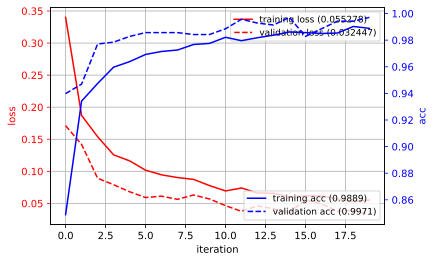

In [12]:
# conv(10,5x5) - Dropout - conv(20,3x3) - Dropout - 100 - 2
K.clear_session()

# initialize random seed
random.seed(4487); tf_set_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5),        # channel, kerne size
              strides=(2,2),    # stride
              activation='relu',
              padding='same',  
              input_shape=(19,19,1),
       ))
nn.add(Dropout(rate=0.5))
nn.add(Conv2D(20, (3,3),        # channel, kerne size
              strides=(1,1),    # stride
              kernel_regularizer=keras.regularizers.l2(0.0001),
              activation='relu', padding='same',
       ))

nn.add(Flatten())   # flatten the feature map into a vector to apply Dense layers
nn.add(Dropout(rate=0.5))
nn.add(Dense(units=100, activation='relu', 
              kernel_regularizer=keras.regularizers.l2(0.0001)
      ))
nn.add(Dense(units=2, activation='softmax',               
             kernel_regularizer=keras.regularizers.l2(0.0001)))
       
# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI, verbose=False)

plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

_How does the MLP compare to the linear and non-linear classifiers that you tried in Tutorial 4?_
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- It's still much worse: 0.734 for CNN, compared to RF of 0.814 accuracy.

## 3. Data Augmentation

Now use data augmentation (introduced in the last tutorial) to try to improve the accuracy.

We can also add per-pixel noise or transformations. We define a few functions for adding per-pixel noise.  The following functions will add Gaussian pixel noise, add corruption noise (setting some input pixels to 0), scale and shift pixel values (changing contrast and brightness).

In [13]:
def add_gauss_noise(X, sigma2=0.05):
    # add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)

def add_corrupt_noise(X, p=0.1):
    # apply pixel corruption (zero out value) with probability p
    return X * random.binomial(1, 1-p, X.shape)

def add_scale_shift(X, sigma2=0.1, alpha2=0.2):
    # randomly scale and shift the pixel values (same for each image)
    # Xnew = a X + b
    # a is sampled from a Gaussian with mean 1, and variance sigma2
    # b is sampled from a Gaussian with mean 0, and variance alpha2
    if X.ndim == 3:
        dshape = (X.shape[0],1,1)
    elif X.ndim == 4:
        dshape = (X.shape[0],1,1,1)
    else:
        dshape = (1,)
    a = random.normal(1,sigma2, dshape)
    b = random.normal(0,alpha2, dshape)
    return minimum(maximum( a*X + b, 0.0), 1.0)

Next, we define a function for adding per-pixel noise (in this case just Gaussian noise). The noise is included using the `preprocessing_function` input of the `ImageDataGenerator`.

In [14]:
# build the noise function
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

Next we can show some examples of augmented images. Run the code below to see different random augmentations.

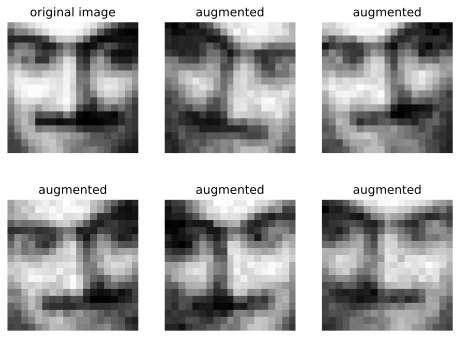

In [15]:
img = trainI[4]
imgs = [img[:,:,0]]

cnt = 0
for augimg, augy in datagen.flow(img.reshape(1,19,19,1), [1], batch_size=1):
    imgs.append(augimg[0,:,:,0])
    cnt += 1
    if cnt > 4:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

titles = ['original image', 'augmented', 'augmented', 'augmented', 'augmented', 'augmented']
plt.figure(figsize=(8,6))
show_imgs(imgs, nc=3, titles=titles)

The augmented images look similar to the original image, but contain small differences that the network can use to learn more about the class.

Now let's try training logistic regression with data augmentation. Instead of "fit", we now  use the "fit_generator" method, which will pass each input through the ImageDataGenerator before sending it to the MLP.  We also disable early stopping so that the training sees more augmented data.

In [16]:
# initialize random seed
K.clear_session()
random.seed(4487); tf_set_seed(4487)

# build the network for logistic regression
nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # vectorize the input image
nn.add(Dense(units=2, activation='softmax'))  # classification layer (2 classes)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_'+accname,             # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.9, nesterov=True), 
           metrics=['accuracy']  # also calculate accuracy during training
          )

# fit with data generator
history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=50),  # data from generator
            steps_per_epoch=len(vtrainI)/50,    # should be number of batches per epoch
            epochs=50,
#           callbacks=callbacks_list, 
            validation_data=validsetI, verbose=True)


/Users/abc/opt/anaconda3/envs/py38tflow2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
125/125 [==============================] - 2s 15ms/step - loss: 0.3622 - accuracy: 0.8465 - val_loss: 0.1926 - val_accuracy: 0.9212
Epoch 2/50
125/125 [==============================] - 2s 12ms/step - loss: 0.1763 - accuracy: 0.9253 - val_loss: 0.1410 - val_accuracy: 0.9384
Epoch 3/50
125/125 [==============================] - 2s 13ms/step - loss: 0.1687 - accuracy: 0.9314 - val_loss: 0.1469 - val_accuracy: 0.9398
Epoch 4/50
125/125 [==============================] - 2s 13ms/step - loss: 0.1744 - accuracy: 0.9334 - val_loss: 0.1345 - val_accuracy: 0.9427
Epoch 5/50
125/125 [==============================] - 2s 17ms/step - loss: 0.1517 - accuracy: 0.9410 - val_loss: 0.0873 - val_accuracy: 0.9656
Epoch 6/50
125/125 [==============================] - 2s 16ms/step - loss: 0.1684 - accuracy: 0.9324 - val_loss: 0.0933 - val_accuracy: 0.9628
Epoch 7/50
125/125 [==============================] - 2s 16ms/step - loss: 0.1640 - accuracy: 0.9363 - val_loss: 0.0891 - val_accuracy: 0.9656

test accuracy: 0.6917372881355932


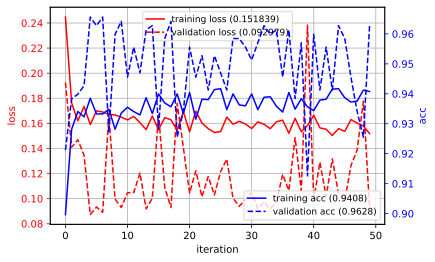

In [17]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

Using data augmentation, the test accuracy improves from 0.622 to 0.692!

Now train your best CNN from the previous section using data augmentation. 
Try different per-pixel noise levels, and different options of the ImageDataGenerator (see [here](https://keras.io/preprocessing/image/)), 
and combinations of them.  Hopefully you should be able to improve the accuracy! 

In [18]:
### INSERT YOUR CODE HERE ###

In [19]:
# define function to train the same network
def trainNN(dg):
    K.clear_session()
    random.seed(4487); tf_set_seed(4487)

    # build the network
    nn = Sequential()
    nn.add(Conv2D(10, (5,5),        # channel, kerne size
                  strides=(2,2),    # stride
                  activation='relu',
                  padding='same',  
                  input_shape=(19,19,1),
           ))
    nn.add(Dropout(rate=0.5))
    nn.add(Conv2D(20, (3,3),        # channel, kerne size
                  strides=(1,1),    # stride
                  kernel_regularizer=keras.regularizers.l2(0.0001),
                  activation='relu', padding='same',
           ))

    nn.add(Flatten())   # flatten the feature map into a vector to apply Dense layers
    nn.add(Dropout(rate=0.5))
    nn.add(Dense(units=100, activation='relu', 
                  kernel_regularizer=keras.regularizers.l2(0.0001)
          ))
    nn.add(Dense(units=2, activation='softmax',               
                 kernel_regularizer=keras.regularizers.l2(0.0001)))

    # compile and fit the network
    nn.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
              metrics=['accuracy'])

    # fit with data generator
    history = nn.fit_generator(
                dg.flow(vtrainI, vtrainYb, batch_size=50),  # data from generator
                steps_per_epoch=len(vtrainI)/50,    # should be number of batches per epoch
                epochs=50,
                validation_data=validsetI, verbose=True)    
    return nn

In [20]:
# build the noise function
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

nn = trainNN(datagen)

/Users/abc/opt/anaconda3/envs/py38tflow2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
125/125 [==============================] - 3s 22ms/step - loss: 0.5247 - accuracy: 0.7274 - val_loss: 0.2389 - val_accuracy: 0.9112
Epoch 2/50
125/125 [==============================] - 3s 22ms/step - loss: 0.2866 - accuracy: 0.8878 - val_loss: 0.2065 - val_accuracy: 0.9255
Epoch 3/50
125/125 [==============================] - 3s 22ms/step - loss: 0.2437 - accuracy: 0.9080 - val_loss: 0.1494 - val_accuracy: 0.9542
Epoch 4/50
125/125 [==============================] - 3s 21ms/step - loss: 0.2123 - accuracy: 0.9206 - val_loss: 0.1594 - val_accuracy: 0.9413
Epoch 5/50
125/125 [==============================] - 3s 21ms/step - loss: 0.1946 - accuracy: 0.9268 - val_loss: 0.1470 - val_accuracy: 0.9527
Epoch 6/50
125/125 [==============================] - 3s 22ms/step - loss: 0.1920 - accuracy: 0.9315 - val_loss: 0.1308 - val_accuracy: 0.9613
Epoch 7/50
125/125 [==============================] - 2s 20ms/step - loss: 0.1867 - accuracy: 0.9357 - val_loss: 0.1390 - val_accuracy: 0.9628

test accuracy: 0.864406779661017


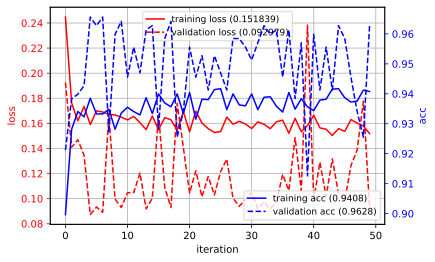

In [21]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

In [22]:
# increase range of shifting, shear, zoom

# build the noise function
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.1,     # image shifting
    height_shift_range=0.1,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

nn = trainNN(datagen)

/Users/abc/opt/anaconda3/envs/py38tflow2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
125/125 [==============================] - 3s 18ms/step - loss: 0.5621 - accuracy: 0.7112 - val_loss: 0.2746 - val_accuracy: 0.9011
Epoch 2/50
125/125 [==============================] - 2s 17ms/step - loss: 0.3237 - accuracy: 0.8713 - val_loss: 0.2472 - val_accuracy: 0.9169
Epoch 3/50
125/125 [==============================] - 2s 17ms/step - loss: 0.2810 - accuracy: 0.8949 - val_loss: 0.2184 - val_accuracy: 0.9327
Epoch 4/50
125/125 [==============================] - 2s 17ms/step - loss: 0.2627 - accuracy: 0.9044 - val_loss: 0.2003 - val_accuracy: 0.9327
Epoch 5/50
125/125 [==============================] - 2s 16ms/step - loss: 0.2579 - accuracy: 0.8970 - val_loss: 0.1918 - val_accuracy: 0.9355
Epoch 6/50
125/125 [==============================] - 2s 16ms/step - loss: 0.2481 - accuracy: 0.9100 - val_loss: 0.1743 - val_accuracy: 0.9427
Epoch 7/50
125/125 [==============================] - 2s 16ms/step - loss: 0.2415 - accuracy: 0.9144 - val_loss: 0.1670 - val_accuracy: 0.9499

test accuracy: 0.9152542372881356


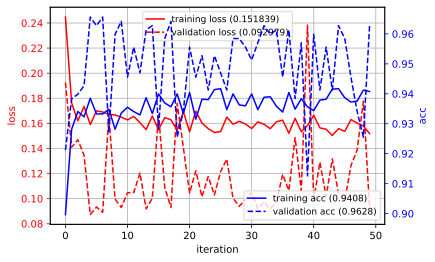

In [23]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

In [24]:
# also add scale_shift noise

# build the noise function
def addNoise(X):
    return add_scale_shift(add_gauss_noise(X, 0.04))

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.1,     # image shifting
    height_shift_range=0.1,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

nn = trainNN(datagen)

/Users/abc/opt/anaconda3/envs/py38tflow2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
125/125 [==============================] - 3s 19ms/step - loss: 0.6194 - accuracy: 0.6755 - val_loss: 0.3997 - val_accuracy: 0.8309
Epoch 2/50
125/125 [==============================] - 2s 18ms/step - loss: 0.4749 - accuracy: 0.7930 - val_loss: 0.2627 - val_accuracy: 0.8911
Epoch 3/50
125/125 [==============================] - 2s 17ms/step - loss: 0.3979 - accuracy: 0.8360 - val_loss: 0.2597 - val_accuracy: 0.9112
Epoch 4/50
125/125 [==============================] - 2s 18ms/step - loss: 0.3751 - accuracy: 0.8452 - val_loss: 0.2115 - val_accuracy: 0.9241
Epoch 5/50
125/125 [==============================] - 2s 18ms/step - loss: 0.3499 - accuracy: 0.8621 - val_loss: 0.2039 - val_accuracy: 0.9413
Epoch 6/50
125/125 [==============================] - 2s 18ms/step - loss: 0.3336 - accuracy: 0.8613 - val_loss: 0.1934 - val_accuracy: 0.9427
Epoch 7/50
125/125 [==============================] - 2s 18ms/step - loss: 0.3174 - accuracy: 0.8770 - val_loss: 0.1703 - val_accuracy: 0.9470

test accuracy: 0.8728813559322034


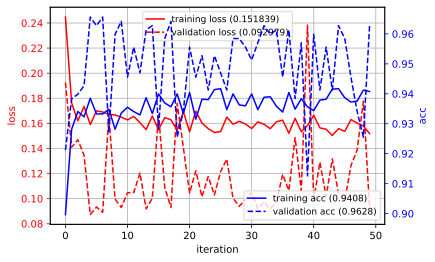

In [25]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

In [26]:
# increase range of shifting, shear, zoom
# BEST

# build the noise function
def addNoise(X):
    return add_corrupt_noise(add_gauss_noise(X, 0.04))

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.1,     # image shifting
    height_shift_range=0.1,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

nn = trainNN(datagen)

/Users/abc/opt/anaconda3/envs/py38tflow2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
125/125 [==============================] - 3s 19ms/step - loss: 0.6042 - accuracy: 0.6792 - val_loss: 0.2818 - val_accuracy: 0.8868
Epoch 2/50
125/125 [==============================] - 2s 17ms/step - loss: 0.3911 - accuracy: 0.8457 - val_loss: 0.2356 - val_accuracy: 0.9155
Epoch 3/50
125/125 [==============================] - 2s 17ms/step - loss: 0.3192 - accuracy: 0.8728 - val_loss: 0.2194 - val_accuracy: 0.9298
Epoch 4/50
125/125 [==============================] - 2s 17ms/step - loss: 0.2887 - accuracy: 0.8884 - val_loss: 0.2540 - val_accuracy: 0.9226
Epoch 5/50
125/125 [==============================] - 2s 17ms/step - loss: 0.2780 - accuracy: 0.8950 - val_loss: 0.2165 - val_accuracy: 0.9241
Epoch 6/50
125/125 [==============================] - 2s 17ms/step - loss: 0.2674 - accuracy: 0.8964 - val_loss: 0.2170 - val_accuracy: 0.9298
Epoch 7/50
125/125 [==============================] - 2s 17ms/step - loss: 0.2595 - accuracy: 0.9028 - val_loss: 0.1778 - val_accuracy: 0.9384

test accuracy: 0.9036016949152542


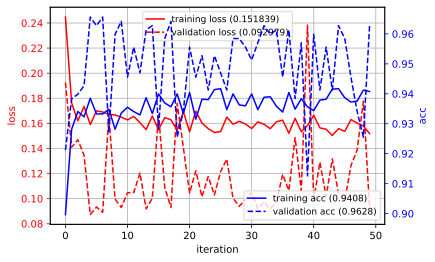

In [27]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

In [28]:
# increase range of shifting, shear, zoom

# build the noise function
def addNoise(X):
    return add_gauss_noise(X, 0.1)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.1,     # image shifting
    height_shift_range=0.1,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

nn = trainNN(datagen)


/Users/abc/opt/anaconda3/envs/py38tflow2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
125/125 [==============================] - 3s 17ms/step - loss: 0.5732 - accuracy: 0.6978 - val_loss: 0.2431 - val_accuracy: 0.9183
Epoch 2/50
125/125 [==============================] - 2s 16ms/step - loss: 0.3355 - accuracy: 0.8685 - val_loss: 0.2162 - val_accuracy: 0.9183
Epoch 3/50
125/125 [==============================] - 2s 17ms/step - loss: 0.2916 - accuracy: 0.8891 - val_loss: 0.2162 - val_accuracy: 0.9241
Epoch 4/50
125/125 [==============================] - 2s 16ms/step - loss: 0.2680 - accuracy: 0.9051 - val_loss: 0.2178 - val_accuracy: 0.9327
Epoch 5/50
125/125 [==============================] - 2s 16ms/step - loss: 0.2493 - accuracy: 0.9160 - val_loss: 0.1967 - val_accuracy: 0.9398
Epoch 6/50
125/125 [==============================] - 2s 16ms/step - loss: 0.2379 - accuracy: 0.9101 - val_loss: 0.2094 - val_accuracy: 0.9269
Epoch 7/50
125/125 [==============================] - 2s 16ms/step - loss: 0.2341 - accuracy: 0.9144 - val_loss: 0.1571 - val_accuracy: 0.9441

test accuracy: 0.913135593220339


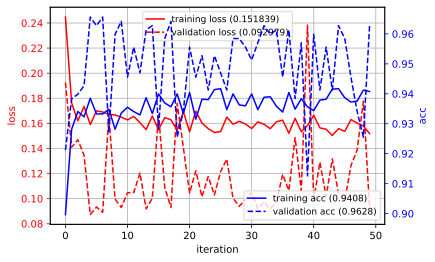

In [29]:

plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

_How does CNN with data augmentation compare with your work in Tutorial 8?_ 
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- Now accuracy is 0.91, which is better than MLP in Tutorial 8.

# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [30]:
fname = "nasa-small.png"

(210, 480)


<ipython-input-31-1ceedb6e5bb3>:5: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  testimg = skimage.color.rgb2gray(testimg3)


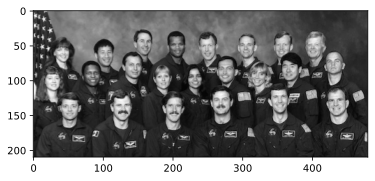

In [31]:
# load image
testimg3 = skimage.io.imread(fname)

# convert to grayscale
testimg = skimage.color.rgb2gray(testimg3)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

In [32]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3], 1))
print(patches2.shape)

# histogram equalize patches (improves contrast)
#newI = empty(patches2.shape)
#for i in range(patches2.shape[0]):
#    newI[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])
newI = patches2

(5568, 19, 19, 1)


Now predict using your classifier.  The extracted images are in `newI`.

In [33]:
### YOUR CODE HERE
prednewY = argmax(nn.predict(newI), axis=-1)

Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

(-0.5, 479.5, 209.5, -0.5)

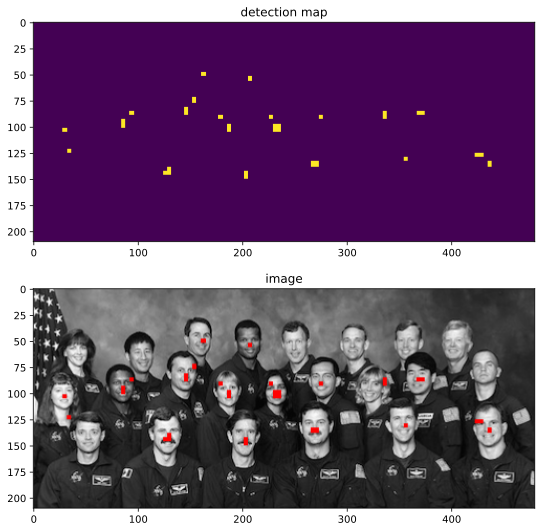

In [34]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

_How did your face detector do compared to the last version?_
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- detected more faces than MLP
- similar number of FP

You can try it on your own images.  The faces should all be around 19x19 pixels though. We only used 1/8 of the training data. Try using more data to train it!